In [1]:
import itertools as itt
import pathlib as pl
import joblib as jl
from configparser import ConfigParser

import numpy as np
from scipy.stats import ranksums
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib as jl

from IPython.display import display

from src.root_path import config_path
from src.visualization.fancy_plots import savefig

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2021-11-01 190042.log
[numexpr.utils INFO] NumExpr defaulting to 8 threads.


In [2]:
# plt.style.use(['dark_background', config_path / 'notebook.mplstyle'])
# plt.style.use(['default', config_path / 'notebook.mplstyle'])
plt.style.use(['default', config_path / 'presentation.mplstyle'])

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))


In [3]:
print('loading DFs...')

tuning_file = pl.Path(config['paths']['analysis_cache']) / '211020_ftc_summary_df'
tuning_df = jl.load(tuning_file)

wf_df_file = pl.Path(config['paths']['analysis_cache']) / '211028_classified_waveform_summary_df'
wf_df = jl.load(wf_df_file)

wf_df = wf_df.dropna(subset=['ptr', 'es', 'sw', 'waveform_norm', 'phototag'])

merge = pd.merge(tuning_df, wf_df, how='inner', on='cellid', validate='m:1')
print('done')



loading DFs...
done


In [13]:
def aling_at_bf(tuning_curves, frequencies, negatives=False, flip=False):
    """
    re stacks the tuning curves in a nan paded array, such that all the best frequencies are aligned
    """
    N, S = tuning_curves.shape
    centered_tuning_curves = np.full((N, S*2), np.nan)
    for cc, curve in enumerate(tuning_curves):
        if negatives:
            bf_idx = np.argmax(np.abs(curve))
        else:
            bf_idx = np.argmax(curve)

        if flip:
             if np.abs(np.min(curve)) >  np.max(curve):
                curve = curve * -1

        centered_tuning_curves[cc, S-bf_idx: S*2-bf_idx] = curve

    bin_octave_size = np.diff(np.log2(frequencies/frequencies[0])).mean().round(decimals=2)
    common_rel_freqs = np.linspace(S*-bin_octave_size, S*bin_octave_size, S*2, endpoint=False)

    # if there is extra nan padding across al neurons, removes it
    mask = ~np.all(np.isnan(centered_tuning_curves), axis=0)
    centered_tuning_curves = centered_tuning_curves[:, mask]
    common_rel_freqs = common_rel_freqs[mask]

    return centered_tuning_curves, common_rel_freqs

def get_aligned_tunings(DF):
    assert DF.duplicated(subset='cellid').any() == False
    frequency = np.asarray(DF.frequency.unique()[0])
    tuning_curves = np.stack(DF['response'].values, axis=0)
    centered_tuning_curves, common_rel_freqs = aling_at_bf(tuning_curves, frequency,
                                                           negatives=True, flip=False)

    return centered_tuning_curves, common_rel_freqs

def plot_signif(data=None, ax=None, yoffset=0, insigif=True, text_style='normal', **kwargs):

    if data is not None:
        left_vals  = data.loc[data[kwargs['x']] == kwargs['order'][0], kwargs['y']].values
        right_vals  = data.loc[data[kwargs['x']] == kwargs['order'][1], kwargs['y']].values
    else:
        x = np.asarray(kwargs['x'])
        xu = np.unique(x)
        assert xu.size == 2
        y = np.asarray(kwargs['y'])
        left_vals = y[x == xu[0]]
        right_vals = y[x == xu[1]]

    stat, pval = ranksums(left_vals, right_vals)
    if insigif == False and pval > 0.05:
        return

    if ax == None:
        ax = plt.gca()

    # defines lines
    y_top, y_bottom = ax.get_ylim()

    line_y_pos = y_bottom + (y_top - y_bottom) * 0.22 + yoffset
    tick_y_pos = line_y_pos + (y_top - y_bottom) * 0.01

    if data is not None:
        line_x = [0, 0, 1, 1]
    else:
        line_x = [xu[0], xu[0], xu[1], xu[1]]

    line_y = [tick_y_pos, line_y_pos, line_y_pos, tick_y_pos]

    # defines  text position
    ypos = line_y_pos - (y_top - y_bottom) * 0.02
    if data is not None:
        xpos = 0.5
    else:
        xpos = (xu[0] + xu[1])/2

    if text_style == 'normal':
        text = f'p={pval:.3f}'
    elif text_style == 'asterisk':
        if pval <= 0.001:
            text = '***'
        elif pval <= 0.01:
            text = '**'
        elif pval <= 0.05:
            text = '*'
        else:
            text = 'NA'
    elif text_style == 'scientific':
        text = f'p={pval:.2e}'

    ax.plot(line_x, line_y, linewidth=2, color='black')
    ax.text(xpos, ypos, text, ha='center', fontsize=15)
    return ax


def get_aligned_waveforms(DF):
    wf = DF['waveform_norm'].values
    trough = DF['trough'].values

    centered = []
    fs = 10000 / (82 / 30000)
    for w, wave in enumerate(wf):
        wave = np.asarray(wave)
        t = int(trough[w])
        wave = wave[t - int(fs * 0.0005):t + int(fs * 0.001)]
        time = np.linspace(-.5, 1, wave.shape[0])
        centered.append(wave)

    centered = np.stack(centered, axis=0)

    return centered, time

def get_ci(array):
    M = np.nanmean(array, axis=0)
    SEM = np.nanstd(array, axis=0) / np.sqrt(array.shape[0])
    return M-SEM , M+SEM


## all tunning curves and statistical analysis

/auto/users/mateo/miniconda3/envs/context_probe_analysis2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 26.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


saving figure at /home/mateo/code/context_probe_analysis/reports/figures/SFN_poster/tuning_comparison.svg
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/SFN_poster/tuning_comparison.png


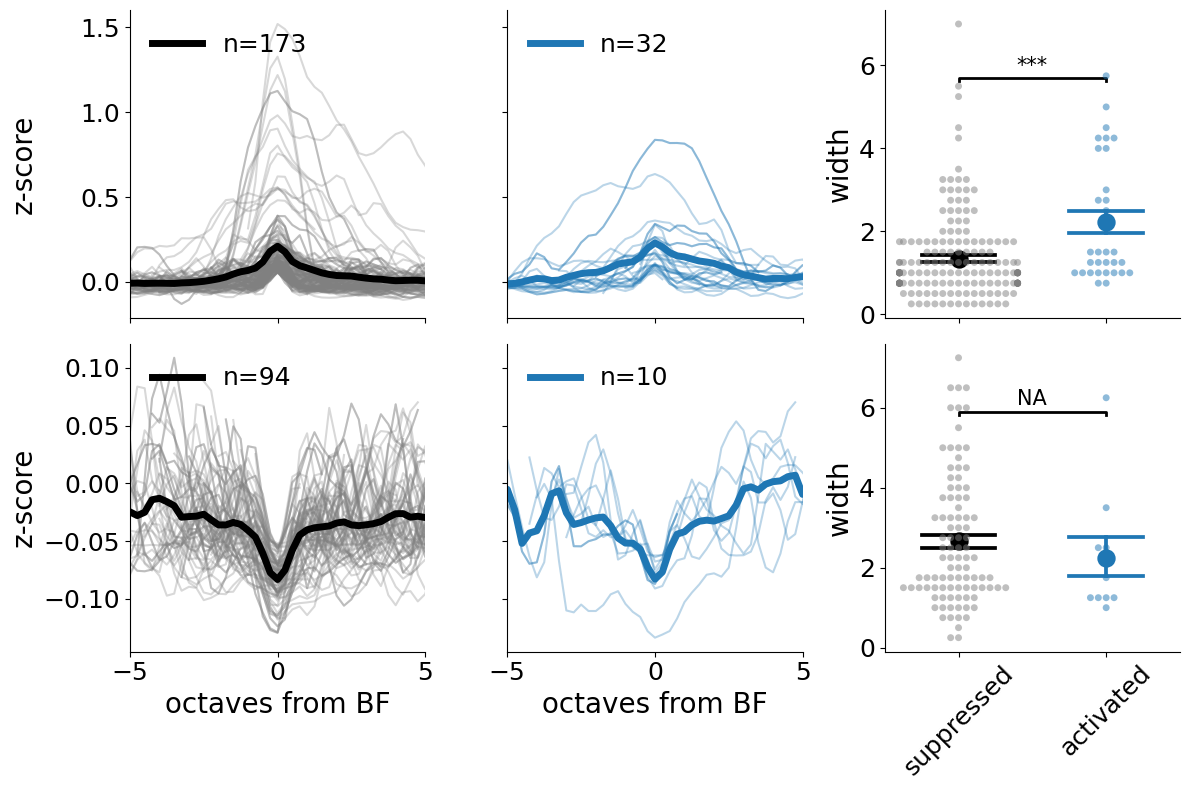

In [18]:
ff_norm = merge.normalization == 'zscore'
ff_metric = merge.metric_name == 'FWHM'
ff_smooth = merge.smooth == 1
ff_part = merge.part == 'onset'

toplot = merge.loc[ff_norm & ff_metric & ff_smooth & ff_part,
                   ['cellid', 'response', 'frequency', 'phototag', 'metric_val', 'bf_resp']]

ff_pos  = toplot.bf_resp > 0.05
ff_neg  = toplot.bf_resp < -0.05

ff_act = toplot.phototag == 'a'
ff_sup = toplot.phototag == 's'


fig = plt.figure(figsize=(12, 8) )
gs = fig.add_gridspec(2, 3)

## top side possitive tuning curves

# suppresed curves
ax0 = fig.add_subplot(gs[0,0])
y, x = get_aligned_tunings(toplot.loc[ff_pos & ff_sup,:])
_ = ax0.plot(x, y.T, color='gray', alpha =0.3)
_ = ax0.plot(x, np.nanmean(y, axis=0), linewidth=5, color='black', label=f'n={y.shape[0]}')
_ = ax0.set_xlim((-5, 5))
_ = ax0.legend(loc='upper left')
plt.setp(ax0.get_xticklabels(), visible=False)
_ = ax0.set_ylabel('z-score')

# activates curves
ax1 = fig.add_subplot(gs[0,1],sharex=ax0, sharey=ax0)
y, x = get_aligned_tunings(toplot.loc[ff_pos & ff_act,:])
_ = ax1.plot(x, y.T, color='C0', alpha =0.3)
_ = ax1.plot(x, np.nanmean(y, axis=0), linewidth=5, color='C0', label=f'n={y.shape[0]}')
_ = ax1.legend(loc='upper left')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax1.get_yticklabels(), visible=False)


# comparison
ax2 = fig.add_subplot(gs[0,2])
_ = sns.swarmplot(data=toplot.loc[ff_pos, :], x='phototag', y='metric_val', order=['s', 'a'],
                  hue='phototag', hue_order=['s', 'a'], palette=['gray', 'C0'], alpha=0.5, ax=ax2)
_ = sns.pointplot(data=toplot.loc[ff_pos, :], x='phototag', y='metric_val', order=['s', 'a'],
                  hue='phototag', hue_order=['s', 'a'], palette=['black', 'C0'],
                  capsize=0.5, scale=1.5, ci=68, ax=ax2)
_ = plot_signif(data=toplot.loc[ff_pos, :], x='phototag', y='metric_val', order=['s', 'a'], ax=ax2, text_style='asterisk')
ax2.get_legend().remove()
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.set_xlabel('')
_ = ax2.set_ylabel('width')


## bottom side negative tuning curves

# suppresed curves
ax3 = fig.add_subplot(gs[1,0], sharex=ax0)
y, x = get_aligned_tunings(toplot.loc[ff_neg & ff_sup,:])
_ = ax3.plot(x, y.T, color='gray', alpha =0.3)
_ = ax3.plot(x, np.nanmean(y, axis=0), linewidth=5, color='black', label=f'n={y.shape[0]}')
_ = ax3.legend(loc='upper left')
_ = ax3.set_xlim((-5, 5))
_ = ax3.set_xlabel('octaves from BF')
_ = ax3.set_ylabel('z-score')

# activated curves
ax4 = fig.add_subplot(gs[1,1],sharex=ax0, sharey=ax3)
y, x = get_aligned_tunings(toplot.loc[ff_neg & ff_act,:])
_ = ax4.plot(x, y.T, color='C0', alpha =0.3)
_ = ax4.plot(x, np.nanmean(y, axis=0), linewidth=5, color='C0', label=f'n={y.shape[0]}')
_ = ax4.legend(loc='upper left')
_ = ax4.set_xlabel('octaves from BF')
plt.setp(ax4.get_yticklabels(), visible=False)


# comparison
ax5 = fig.add_subplot(gs[1,2], sharex=ax2)
_ = sns.swarmplot(data=toplot.loc[ff_neg, :], x='phototag', y='metric_val', order=['s', 'a'],
                  hue='phototag', hue_order=['s', 'a'], palette=['gray', 'C0'], alpha=0.5, ax=ax5)
_ = sns.pointplot(data=toplot.loc[ff_neg, :], x='phototag', y='metric_val', order=['s', 'a'],
                  hue='phototag', hue_order=['s', 'a'], palette=['black', 'C0'],
                  capsize=0.5, scale=1.5, ci=68, ax=ax5)
_ = plot_signif(data=toplot.loc[ff_neg, :], x='phototag', y='metric_val', order=['s', 'a'], ax=ax5,  text_style='asterisk')
ax5.get_legend().remove()
_ = ax5.set_xticklabels(['suppressed', 'activated'], rotation=45, ha='center')
_ = ax5.set_xlabel('')
_ = ax5.set_ylabel('width')

# alight leftmost labels
fig.align_ylabels([ax0, ax3])

# save
title = 'tuning_comparison'
savefig(fig, 'SFN_poster', title, type='svg')
savefig(fig, 'SFN_poster', title, type='png')

## waveform analysis plus tunning

saving figure at /home/mateo/code/context_probe_analysis/reports/figures/SFN_poster/waveform_tuning_relation.svg
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/SFN_poster/waveform_tuning_relation.png


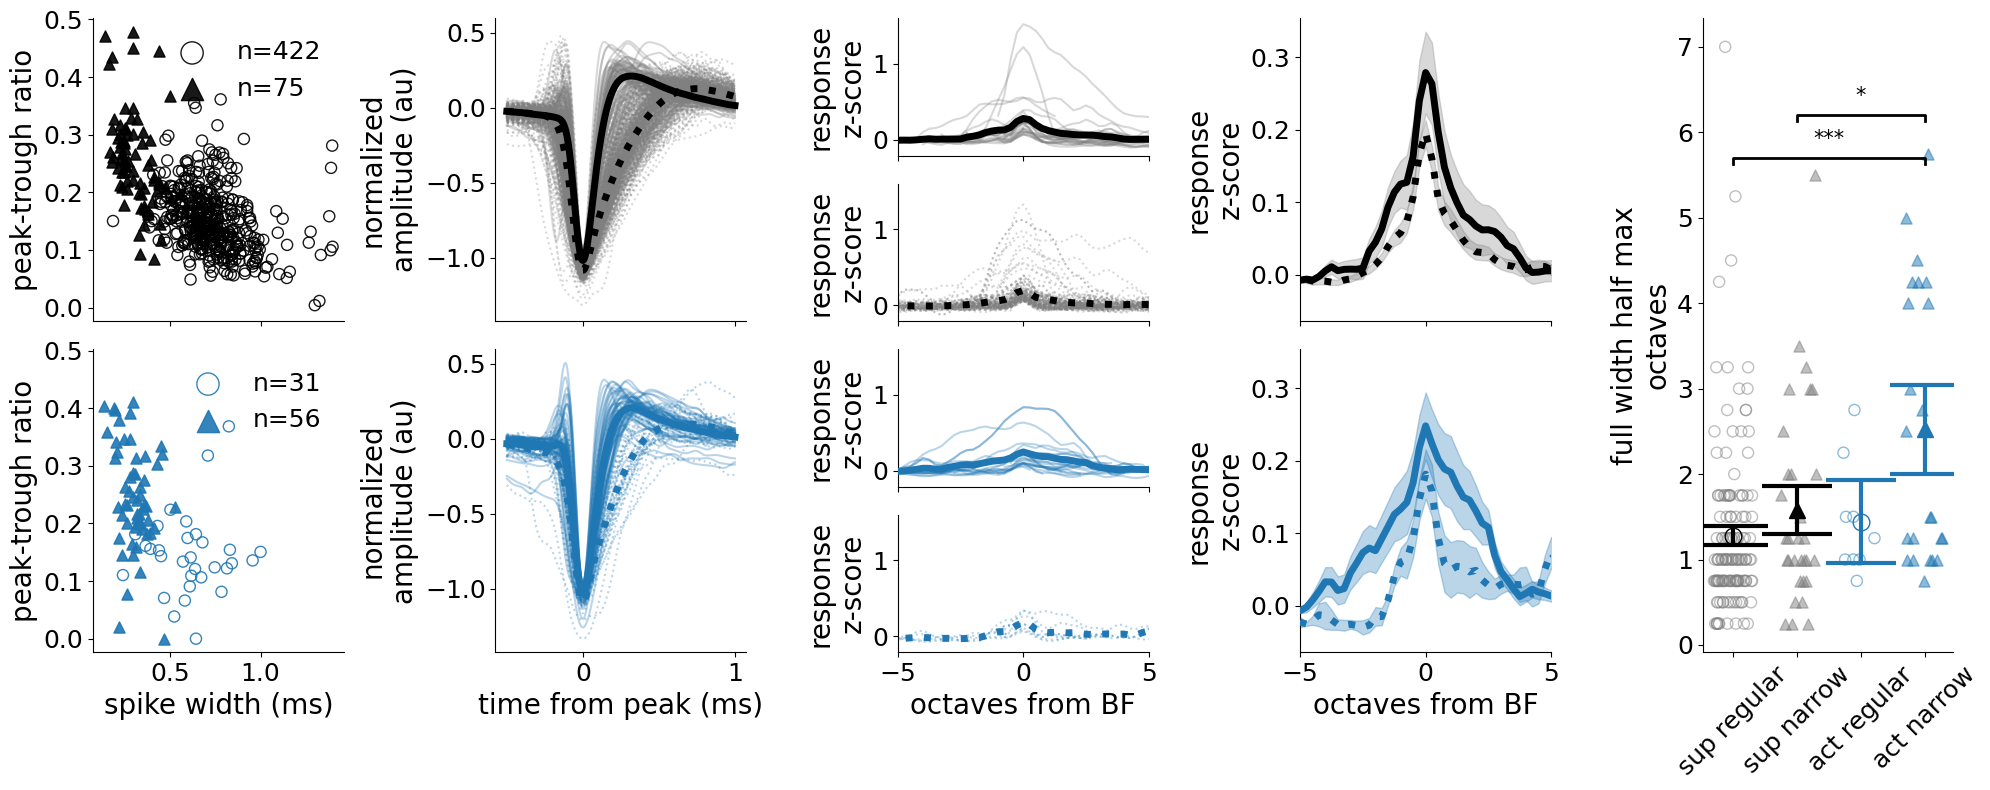

In [16]:


ff_act = wf_df.phototag == 'a'
ff_sup = wf_df.phototag == 's'
ff_rapid  = wf_df.spike_type == 'rapid'
ff_narrow  = wf_df.spike_type == 'narrow'

fig = plt.figure(figsize=(20, 8))
gs = fig.add_gridspec(4, 5)


# left side scatters
ax0 = fig.add_subplot(gs[:2,0])
x = wf_df.loc[ff_sup & ff_rapid, 'sw']
y = wf_df.loc[ff_sup & ff_rapid, 'ptr']
_ = ax0.scatter(x, y, facecolors='none', edgecolors='black', marker='o', alpha=0.9,
                label=f'n={len(y)}')

x = wf_df.loc[ff_sup & ff_narrow, 'sw']
y = wf_df.loc[ff_sup & ff_narrow, 'ptr']
_ = ax0.scatter(x, y, color='black', marker='^', alpha=0.9, label=f'n={len(y)}')
plt.setp(ax0.get_xticklabels(), visible=False)
_ = ax0.set_ylabel('peak-trough ratio')
_ = ax0.legend()

ax1 = fig.add_subplot(gs[2:,0], sharex=ax0, sharey=ax0)
x = wf_df.loc[ff_act & ff_rapid, 'sw']
y = wf_df.loc[ff_act & ff_rapid, 'ptr']
_ = ax1.scatter(x, y, facecolors='none', edgecolors='C0', marker='o', alpha=0.9,
                label=f'n={len(y)}')

x = wf_df.loc[ff_act & ff_narrow, 'sw']
y = wf_df.loc[ff_act & ff_narrow, 'ptr']
_ = ax1.scatter(x, y, color='C0', marker='^', alpha=0.9, label=f'n={len(y)}')
_ = ax1.set_xlabel('spike width (ms)')
_ = ax1.set_ylabel('peak-trough ratio')
_ = ax1.legend()

# centere waveforms
ax2 = fig.add_subplot(gs[:2,1])
y, x = get_aligned_waveforms(wf_df.loc[ff_sup & ff_rapid, :])
_ = ax2.plot(x, y.T, linestyle=':', color='grey', alpha=0.3)
_ = ax2.plot(x, y.mean(axis=0), linestyle=':', color='black', linewidth=5, zorder=500)

y, x = get_aligned_waveforms(wf_df.loc[ff_sup & ff_narrow, :])
_ = ax2.plot(x, y.T, linestyle='-', color='gray', alpha=0.3)
_ = ax2.plot(x, y.mean(axis=0), linestyle='-', color='black', linewidth=5, zorder=500)
plt.setp(ax2.get_xticklabels(), visible=False)
_ = ax2.set_ylabel('normalized\namplitude (au)')

ax3 = fig.add_subplot(gs[2:,1], sharex=ax2, sharey=ax2)
y, x = get_aligned_waveforms(wf_df.loc[ff_act & ff_rapid, :])
_ = ax3.plot(x, y.T, linestyle=':', color='C0', alpha=0.3)
_ = ax3.plot(x, y.mean(axis=0), linestyle=':', color='C0', linewidth=5, zorder=500)

y, x = get_aligned_waveforms(wf_df.loc[ff_act & ff_narrow, :])
_ = ax3.plot(x, y.T, linestyle='-', color='C0', alpha=0.3)
_ = ax3.plot(x, y.mean(axis=0), linestyle='-', color='C0', linewidth=5, zorder=500)
_ = ax3.set_xlabel('time from peak (ms)')
_ = ax3.set_ylabel('normalized\namplitude (au)')


#### rightsiede tunings ####

ff_norm = merge.normalization == 'zscore'
ff_metric = merge.metric_name == 'FWHM'
ff_smooth = merge.smooth == 1
ff_part = merge.part == 'onset'
ff_pos = merge.bf_resp > 0.05

toplot = merge.loc[ff_norm & ff_metric & ff_smooth & ff_part & ff_pos,
                   ['cellid', 'response', 'frequency', 'phototag', 'metric_val', 'bf_resp',
                    'sw', 'ptr', 'es', 'waveform_norm', 'trough', 'spike_type']
                  ].dropna(subset=['sw', 'ptr', 'es', 'waveform_norm', 'phototag'])


ff_act = toplot.phototag == 'a'
ff_sup = toplot.phototag == 's'
ff_rapid  = toplot.spike_type == 'rapid'
ff_narrow  = toplot.spike_type == 'narrow'


ax4 = fig.add_subplot(gs[0,2])
y, x = get_aligned_tunings(toplot.loc[ff_sup & ff_narrow, :])
_ = ax4.plot(x, y.T, linestyle='-', color='grey', alpha=0.3)
_ = ax4.plot(x, np.nanmean(y, axis=0), linestyle='-', color='black', linewidth=5, zorder=500)
_ = ax4.set_ylabel('response\nz-score')
plt.setp(ax4.get_xticklabels(), visible=False)
_ = ax4.set_xlim([-5,5])

ax5 = fig.add_subplot(gs[1,2], sharex=ax4, sharey=ax4)
y, x = get_aligned_tunings(toplot.loc[ff_sup & ff_rapid, :])
_ = ax5.plot(x, y.T, linestyle=':', color='grey', alpha=0.3)
_ = ax5.plot(x, np.nanmean(y, axis=0), linestyle=':', color='black', linewidth=5, zorder=500)
_ = ax5.set_ylabel('response\nz-score')
plt.setp(ax5.get_xticklabels(), visible=False)

ax6 = fig.add_subplot(gs[2,2], sharex=ax4, sharey=ax4)
y, x = get_aligned_tunings(toplot.loc[ff_act & ff_narrow, :])
_ = ax6.plot(x, y.T, linestyle='-', color='C0', alpha=0.3)
_ = ax6.plot(x, np.nanmean(y, axis=0), linestyle='-', color='C0', linewidth=5, zorder=500)
_ = ax6.set_ylabel('response\nz-score')
plt.setp(ax6.get_xticklabels(), visible=False)

ax7 = fig.add_subplot(gs[3,2], sharex=ax4, sharey=ax4)
y, x = get_aligned_tunings(toplot.loc[ff_act & ff_rapid, :])
_ = ax7.plot(x, y.T, linestyle=':', color='C0', alpha=0.3)
_ = ax7.plot(x, np.nanmean(y, axis=0), linestyle=':', color='C0', linewidth=5, zorder=500)
_ = ax7.set_xlabel('octaves from BF')
_ = ax7.set_ylabel('response\nz-score')


### tuning mean comparisons ####

ax8 = fig.add_subplot(gs[:2,3])
y, x = get_aligned_tunings(toplot.loc[ff_sup & ff_narrow, :])
ci0, ci1 = get_ci(y)
_ = ax8.plot(x, np.nanmean(y, axis=0), linestyle='-', color='black', linewidth=5, zorder=500)
_ = ax8.fill_between(x, ci0, ci1, color='gray', alpha=0.3,)
_ = ax8.set_xlim([-5,5])

y, x = get_aligned_tunings(toplot.loc[ff_sup & ff_rapid, :])
ci0, ci1 = get_ci(y)
# _ = ax5.plot(x, y.T, linestyle=':', color='grey', alpha=0.3)
_ = ax8.plot(x, np.nanmean(y, axis=0), linestyle=':', color='black', linewidth=5, zorder=500)
_ = ax8.fill_between(x, ci0, ci1, color='gray', alpha=0.3,)
_ = ax8.set_ylabel('response\nz-score')
plt.setp(ax8.get_xticklabels(), visible=False)

ax9 = fig.add_subplot(gs[2:,3], sharex=ax8, sharey=ax8)
y, x = get_aligned_tunings(toplot.loc[ff_act & ff_narrow, :])
ci0, ci1 = get_ci(y)
_ = ax9.plot(x, np.nanmean(y, axis=0), linestyle='-', color='C0', linewidth=5, zorder=500)
_ = ax9.fill_between(x, ci0, ci1, color='C0', alpha=0.3,)


y, x = get_aligned_tunings(toplot.loc[ff_act & ff_rapid, :])
ci0, ci1 = get_ci(y)
# _ = ax7.plot(x, y.T, linestyle=':', color='C0', alpha=0.3)
_ = ax9.plot(x, np.nanmean(y, axis=0), linestyle=':', color='C0', linewidth=5, zorder=500)
_ = ax9.fill_between(x, ci0, ci1, color='C0', alpha=0.3,)
_ = ax9.set_xlabel('octaves from BF')
_ = ax9.set_ylabel('response\nz-score')


### rightmost quantification

ff_norm = merge.normalization == 'zscore'
ff_metric = merge.metric_name == 'FWHM'
ff_smooth = merge.smooth == 1
ff_part = merge.part == 'onset'
ff_pos = merge.bf_resp > 0.05

toplot = merge.loc[ff_norm & ff_metric & ff_smooth & ff_part & ff_pos,
                   ['cellid', 'response', 'frequency', 'phototag', 'metric_val', 'bf_resp',
                    'sw', 'ptr', 'es', 'waveform_norm', 'trough', 'spike_type']
                  ].dropna(subset=['sw', 'ptr', 'es', 'waveform_norm', 'phototag'])


ff_act = toplot.phototag == 'a'
ff_sup = toplot.phototag == 's'
ff_rapid  = toplot.spike_type == 'rapid'
ff_narrow  = toplot.spike_type == 'narrow'


ax = fig.add_subplot(gs[:,4])


face = ['none', 'black', 'none', 'C0']
edge = ['black', 'black', 'C0', 'C0']
marker = ['o', '^', 'o', '^']
act_filt = [ff_sup, ff_sup, ff_act, ff_act]
wav_filt = [ff_rapid, ff_narrow, ff_rapid, ff_narrow]


group = []
for  xo, (f, e, m, a, w) in enumerate(zip(face, edge, marker, act_filt, wav_filt)):
    y = toplot.loc[a & w, 'metric_val'].values
    x = np.full_like(y, xo)
    x += np.random.uniform(-0.3, 0.3, size=x.shape)

    fs = 'gray' if f=='black' else f
    es = 'gray' if e=='black' else e


    _ = ax.scatter(x=x, y=y, facecolors=fs, edgecolors=es, marker=m, alpha=0.5)
    # _ = ax.scatter(x=xo, y=np.mean(y), facecolor=f, edgecolors=e, marker=m, s=200)
    sem = np.mean(y) / np.sqrt(y.size)
    _ = ax.errorbar(x=xo, y=np.mean(y), marker=m,  yerr=sem,
                    markerfacecolor=f, markeredgecolor=e, markersize=12,
                    ecolor=e, elinewidth=3, capthick=3, capsize=25,)

    group.append(y)

n=0
for a, b in itt.combinations(range(4),2):
    y = np.concatenate((group[a],group[b]))
    x = np.concatenate((np.full_like(group[a], a),np.full_like(group[b], b)))
    out = plot_signif(x=x, y=y, ax=ax, yoffset=n*0.5, insigif=False, text_style='asterisk')
    if out is not None: n+=1


_ = ax.set_ylabel('full width half max\noctaves')
_ = ax.set_xticks([0, 1, 2, 3])
_ = ax.set_xticklabels(['sup regular', 'sup narrow',
                    'act regular', 'act narrow'],
                   rotation=45, ha='center')


# save figure
title = 'waveform_tuning_relation'
savefig(fig, 'SFN_poster', title, type='svg')
savefig(fig, 'SFN_poster', title, type='png')
